<a href="https://colab.research.google.com/github/heugyu/coin_deep_learning/blob/master/BTC_LSTM_30M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler


if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

In [47]:
# 구글 드라이브 csv read
data = pd.read_csv('/content/drive/My Drive/DATA/BITSTAMP_BTCUSD_30.csv')
print(f'데이터 shape : {data.shape}')
data.head()

데이터 shape : (20642, 61)


,time,open,high,low,close,Mean,Upper,Lower,Upper fib,low fib,Plot,Plot.1,Plot.2,ParabolicSAR,H,M,L,wca,RES,SUP,Shapes,Shapes.1,EMA_34,EMA_90,EMA_100,EMA_144,EMA_200,short_line,RES.1,RES_CLOSE,SUP.1,SUP_CLOSE,VWAP,34 EMA,Volume,Volume MA,Bitfinex (USD),Coinbase (USD),Bitstamp (USD),Kraken (USD),HitBTC (USD),CEX.io (USD),Binance (USDT),Bittrex (USDT),Poloniex (USDT),bitFlyer (JPY),Bithumb (KRW),Korbit (KRW),Kraken (EUR),Bitfinex (EUR),Bitstamp (EUR),Coinbase (EUR),Volume.1,A/D Volume,Volume EMA,A/D Volume EMA,A/D Buy MA,A/D Sell MA,OnBalanceVolume,MF,Accumulation/Distribution
0,1546300800,3693.85,3698.79,3683.45,3688.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,3690.363333,3772.823236,33.633692,NaN,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,7.277663e+07,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,-9.954170
1,1546302600,3688.85,3703.25,3688.85,3693.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3683.4500,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,3693.548804,3772.823236,60.833166,NaN,407313.261684,681330.350910,77222.072074,140835.504549,8.689055e+05,6557.405676,803971.883778,985416.710187,18827.759069,228461.856712,61138.190113,19330.049509,0.0,0.0,0.0,0.0,8.162056e+07,5.062764e+08,NaN,NaN,NaN,NaN,60.833166,NaN,-28.711062
2,1546304400,3692.89,3699.35,3685.34,3691.65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3683.4500,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,3692.981234,3772.823236,61.777367,NaN,19211.177974,423231.053272,52043.157477,43685.080807,9.086327e+04,981.107861,226684.675153,484473.694572,402.920974,111388.411209,9352.249563,5243.912213,0.0,0.0,0.0,0.0,8.406477e+07,2.043791e+08,NaN,NaN,NaN,NaN,-0.944201,NaN,-34.840294
3,1546306200,3691.94,3698.26,3676.13,3681.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3703.2500,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,3691.403314,3767.586479,39.679448,NaN,292940.624789,744641.195896,45746.654298,97486.158352,1.086018e+06,4917.248561,568775.557130,468750.594552,1381.444223,77485.553104,65918.859704,33080.335981,0.0,0.0,0.0,0.0,1.040063e+08,4.291314e+08,NaN,NaN,NaN,NaN,-40.623650,NaN,-56.410279
4,1546308000,3681.18,3683.55,3665.00,3675.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3702.7076,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,3686.585908,3767.586479,78.724227,NaN,170078.710728,133871.139442,165198.768972,124994.649936,4.960924e+05,338.728664,556796.146926,890663.295374,4977.569762,65238.536984,29066.257405,8126.482301,0.0,0.0,0.0,0.0,8.810634e+07,2.887263e+08,NaN,NaN,NaN,NaN,-119.347877,NaN,-48.219564


In [48]:
data.describe()

,time,open,high,low,close,Mean,Upper,Lower,Upper fib,low fib,Plot,Plot.1,Plot.2,ParabolicSAR,H,M,L,wca,RES,SUP,Shapes,Shapes.1,EMA_34,EMA_90,EMA_100,EMA_144,EMA_200,short_line,RES.1,RES_CLOSE,SUP.1,SUP_CLOSE,VWAP,34 EMA,Volume,Volume MA,Bitfinex (USD),Coinbase (USD),Bitstamp (USD),Kraken (USD),HitBTC (USD),CEX.io (USD),Binance (USDT),Bittrex (USDT),Poloniex (USDT),bitFlyer (JPY),Bithumb (KRW),Korbit (KRW),Kraken (EUR),Bitfinex (EUR),Bitstamp (EUR),Coinbase (EUR),Volume.1,A/D Volume,Volume EMA,A/D Volume EMA,A/D Buy MA,A/D Sell MA,OnBalanceVolume,MF,Accumulation/Distribution
count,2.064200e+04,20642.000000,20642.000000,20642.000000,20642.000000,20543.000000,20543.000000,20543.000000,20543.000000,20543.000000,20444.000000,20444.000000,20444.000000,20641.000000,20624.000000,20613.000000,20624.000000,0.0,20642.000000,20642.000000,547.000000,539.000000,20609.000000,20553.000000,20543.000000,20499.000000,20443.000000,20608.000000,20642.000000,20642.000000,20642.000000,20642.000000,20642.000000,20642.000000,20642.000000,20623.000000,2.064200e+04,2.064200e+04,2.064200e+04,2.064200e+04,2.064200e+04,2.064200e+04,2.064200e+04,2.064200e+04,2.064200e+04,2.064200e+04,2.064200e+04,2.064200e+04,2.064200e+04,2.064200e+04,2.064200e+04,2.064200e+04,2.064200e+04,2.064200e+04,2.063600e+04,2.063600e+04,1.061900e+04,1.001000e+04,20641.000000,20623.000000,20642.000000
mean,1.564879e+09,7593.620705,7619.275183,7566.293591,7593.565300,7595.274579,7896.055921,7294.493237,7754.087128,7436.462031,7716.451984,7542.391757,7368.331531,7592.112955,7823.832015,7591.803380,7355.639109,NaN,7917.663749,6834.541548,7680.670859,7393.119759,7595.518128,7598.929603,7599.536269,7602.292658,7605.861888,7600.096283,7786.842846,7764.843249,7349.988474,7375.080380,6237.254342,7577.068196,164.362999,164.441195,6.967765e+05,8.655777e+05,5.127072e+05,4.179171e+05,1.418361e+06,1.350171e+04,3.004010e+06,3.008328e+06,8.605835e+04,3.401792e+05,4.163349e+05,3.493822e+04,3.279649e+05,5.838542e+04,1.004047e+05,1.184494e+05,3.404718e+08,2.003106e+09,3.405069e+08,2.003382e+09,2.009302e+09,1.996718e+09,34826.016974,0.026751,93153.993840
std,1.072761e+07,2525.592109,2538.752768,2510.911375,2525.185094,2511.304468,2667.028984,2371.814785,2591.682637,2435.446305,2554.365944,2472.656829,2399.449363,2526.654529,2641.117131,2520.688700,2409.426453,NaN,2712.046762,2558.659808,2600.129191,2443.655743,2521.076993,2514.789289,2513.739085,2509.084971,2503.125769,2527.418408,2657.411217,2644.963849,2432.573594,2444.242528,1829.088445,2521.084260,229.562737,131.018296,2.115903e+06,2.287899e+06,1.190448e+06,1.847319e+06,2.472708e+06,4.497780e+04,5.399650e+06,5.284477e+06,1.918732e+05,7.005718e+05,1.897742e+06,1.609397e+06,8.701721e+05,2.140002e+05,2.674949e+05,3.589774e+05,4.212248e+08,3.934315e+09,3.077810e+08,2.381160e+09,2.008071e+09,2.008356e+09,22727.057760,0.144240,52346.378750
min,1.546301e+09,3346.500000,3357.490000,3322.190000,3346.370000,3357.900000,3387.100000,3322.190000,3373.317600,3342.482400,3375.729385,3358.179068,3294.007642,3322.190000,3390.195219,3361.149671,3332.104122,NaN,0.000000,0.000000,3383.290000,3322.190000,3360.439129,3368.224443,3369.773902,3376.339785,3383.700792,1692.876411,0.000000,0.000000,0.000000,0.000000,3620.957401,3375.170221,0.004639,11.557998,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.067351e+07,0.000000e+00,2.860866e+07,5.728367e+07,1.682892e+08,1.206835e+08,-8918.462251,-0.525169,-1301.239053
25%,1.555589e+09,5204.307500,5217.730000,5189.047500,5204.970000,5205.355000,5347.370000,5071.580000,5288.422360,5120.179320,5296.630667,5181.349345,5112.103519,5198.907201,5329.066820,5201.775605,5045.910598,NaN,5282.000000,3850.450000,5271.220000,5048.155000,5212.433911,5205.642814,5204.358484,5211.810177,5213.982291,5216.439969,5284.605000,5279.260000,5099.000000,5115.980000,4084.433969,5191.333174,47.

In [49]:
print(len(data))

copy_data = data[['open', 'high', 'low', 'close', 
                  'Mean ', 'Upper ', 'Lower', 'Upper fib ', 'low fib', 'Plot', 'Plot.1', 'Plot.2',
                  'ParabolicSAR',
                  'H', 'M', 'L', 'RES', 'SUP','EMA_34', 
                  'short_line', 'VWAP', '34 EMA', 'Volume', 'Volume.1', 'A/D Volume', 
                  'OnBalanceVolume', 'MF', 'Accumulation/Distribution']].dropna()

print(len(copy_data))

20642
20444


In [50]:
#   MINMAX scale
    #   가격 
    #   볼륨
    #   OBV
    #   MF
    #   A/D
copy_data.head()

,open,high,low,close,Mean,Upper,Lower,Upper fib,low fib,Plot,Plot.1,Plot.2,ParabolicSAR,H,M,L,RES,SUP,EMA_34,short_line,VWAP,34 EMA,Volume,Volume.1,A/D Volume,OnBalanceVolume,MF,Accumulation/Distribution
198,3841.48,3841.71,3832.00,3833.54,3809.735,3887.09,3732.38,3850.57844,3768.89156,3890.978173,3825.772241,3760.566308,3815.512164,3863.289424,3805.969105,3748.648786,3845.46,0.0,3807.070243,3802.163957,3788.521674,3799.236736,33.643355,8.877153e+07,5.924984e+08,-2808.806380,-0.125193,-1052.378325
199,3836.12,3847.11,3836.12,3841.39,3809.735,3887.09,3732.38,3850.57844,3768.89156,3890.185673,3825.433942,3760.682211,3821.238391,3863.569322,3806.618437,3749.667553,3845.46,0.0,3809.031372,3804.560838,3788.593295,3801.645494,31.709355,7.783730e+07,5.332126e+08,-2777.097025,-0.148615,-1053.676706
200,3843.91,3854.40,3840.07,3846.44,3809.735,3887.09,3732.38,3850.57844,3768.89156,3889.342970,3825.065099,3760.787228,3826.506520,3863.826350,3807.262051,3750.697752,3845.46,0.0,3811.169008,3806.919633,3788.678851,3801.645494,34.453020,7.513843e+07,2.485333e+08,-2742.644004,-0.141077,-1057.499476
201,3845.02,3852.23,3839.47,3839.47,3809.735,3887.09,3732.38,3850.57844,3768.89156,3888.449625,3824.665711,3760.881797,3831.353198,3864.086102,3807.900313,3751.714525,3845.46,0.0,3812.786208,3809.161581,3788.797716,3801.645494,50.873609,9.328452e+07,3.873040e+07,-2793.517614,-0.146709,-1108.373086
202,3842.56,3859.33,3840.01,3856.15,3809.735,3887.09,3732.38,3850.57844,3768.89156,3887.505168,3824.235778,3760.966387,3835.812142,3864.302740,3808.533521,3752.764302,3845.46,0.0,3815.264139,3811.457914,3788.918373,3801.645494,45.182568,1.063852e+08,3.723424e+08,-2748.335045,-0.154140,-1078.064282


In [51]:

#   스케일러 설정 
price_scaler = MinMaxScaler()
vol_scaler = MinMaxScaler()
obv_scaler = MinMaxScaler()
mf_scaler = MinMaxScaler()
ad_scaler = MinMaxScaler()

#   스케일 데이터 fitting
price_scaler.fit(np.array(copy_data[['open', 'high', 'low', 'close', 'Mean ', 'Upper ', 
                                     'Lower', 'Upper fib ', 'low fib', 'Plot', 'Plot.1', 
                                     'Plot.2', 'ParabolicSAR', 'H', 'M', 'L', 'RES', 'SUP', 
                                     'EMA_34', 'short_line', 'VWAP', '34 EMA']]).reshape(-1, 1))
vol_scaler.fit(np.array(copy_data[['Volume', 'Volume.1', 'A/D Volume']]).reshape(-1, 1))
obv_scaler.fit(np.array(copy_data[['OnBalanceVolume']]).reshape(-1, 1))
mf_scaler.fit(np.array(copy_data[['MF']]).reshape(-1, 1))
ad_scaler.fit(np.array(copy_data[['Accumulation/Distribution']]).reshape(-1, 1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [52]:
#   학습데이터 0 ~ 1 스케일 
copy_data[['open', 'high', 'low', 'close', 'Mean ', 'Upper ', 
           'Lower', 'Upper fib ', 'low fib', 'Plot', 'Plot.1', 
           'Plot.2', 'ParabolicSAR', 'H', 'M', 'L', 'RES', 'SUP', 
           'EMA_34', 'short_line', 'VWAP', '34 EMA']] = price_scaler.transform(np.array(copy_data[['open', 'high', 'low', 'close', 'Mean ', 
                                                                                                   'Upper ', 'Lower', 'Upper fib ', 'low fib', 
                                                                                                   'Plot', 'Plot.1', 'Plot.2', 'ParabolicSAR', 
                                                                                                   'H', 'M', 'L', 'RES', 'SUP', 'EMA_34', 'short_line', 
                                                                                                   'VWAP', '34 EMA']]).reshape(-1, 22))
copy_data[['Volume', 'Volume.1', 'A/D Volume']] = vol_scaler.transform(np.array(copy_data[['Volume', 'Volume.1', 'A/D Volume']]).reshape(-1, 3))
copy_data[['OnBalanceVolume']] = obv_scaler.transform(np.array(copy_data[['OnBalanceVolume']]).reshape(-1, 1))
copy_data[['MF']] = mf_scaler.transform(np.array(copy_data[['MF']]).reshape(-1, 1))
copy_data[['Accumulation/Distribution']] = ad_scaler.transform(np.array(copy_data[['Accumulation/Distribution']]).reshape(-1, 1))

print(len(copy_data.columns) - 1)
copy_data.head()

27


,open,high,low,close,Mean,Upper,Lower,Upper fib,low fib,Plot,Plot.1,Plot.2,ParabolicSAR,H,M,L,RES,SUP,EMA_34,short_line,VWAP,34 EMA,Volume,Volume.1,A/D Volume,OnBalanceVolume,MF,Accumulation/Distribution
198,0.276764,0.276780,0.276081,0.276192,0.274477,0.28005,0.268903,0.277419,0.271534,0.280330,0.275632,0.270934,0.274893,0.278335,0.274205,0.270076,0.27705,0.0,0.274285,0.273931,0.272948,0.273720,3.056649e-10,0.000807,0.005384,0.080587,0.352582,0.000384
199,0.276378,0.277169,0.276378,0.276757,0.274477,0.28005,0.268903,0.277419,0.271534,0.280273,0.275608,0.270943,0.275305,0.278355,0.274252,0.270149,0.27705,0.0,0.274426,0.274104,0.272953,0.273894,2.880912e-10,0.000707,0.004845,0.081006,0.331934,0.000376
200,0.276939,0.277695,0.276662,0.277121,0.274477,0.28005,0.268903,0.277419,0.271534,0.280212,0.275581,0.270950,0.275685,0.278374,0.274298,0.270223,0.27705,0.0,0.274580,0.274274,0.272960,0.273894,3.130221e-10,0.000683,0.002258,0.081460,0.338579,0.000349
201,0.277019,0.277538,0.276619,0.276619,0.274477,0.28005,0.268903,0.277419,0.271534,0.280148,0.275552,0.270957,0.276034,0.278392,0.274344,0.270296,0.27705,0.0,0.274696,0.274435,0.272968,0.273894,4.622310e-10,0.000848,0.000352,0.080789,0.333614,0.000000
202,0.276841,0.278050,0.276658,0.277821,0.274477,0.28005,0.268903,0.277419,0.271534,0.280080,0.275521,0.270963,0.276355,0.278408,0.274390,0.270372,0.27705,0.0,0.274875,0.274601,0.272977,0.273894,4.105182e-10,0.000967,0.003383,0.081385,0.327064,0.000208


In [7]:
copy_data.describe()

,open,high,low,close,H,M,L,RES,SUP,EMA_34,short_line,VWAP,34 EMA,Volume,Volume.1,A/D Volume,OnBalanceVolume,MF
count,20547.000000,20547.000000,20547.000000,20547.000000,20547.000000,20547.000000,20547.000000,20547.000000,20547.000000,20547.000000,20547.000000,20547.000000,20547.000000,2.054700e+04,20547.000000,2.054700e+04,20547.000000,20547.000000
mean,0.555177,0.556813,0.553442,0.555194,0.571212,0.554702,0.538191,0.580733,0.498583,0.554896,0.555131,0.447407,0.554059,1.120885e-10,0.000179,1.469293e-03,0.377839,0.506626
std,0.180570,0.181441,0.179591,0.180560,0.188798,0.180402,0.172501,0.196224,0.181078,0.180475,0.180876,0.125720,0.180331,2.208584e-10,0.000222,1.028367e-02,0.235261,0.117699
min,0.249041,0.249760,0.247408,0.249034,0.252569,0.250091,0.247612,0.000000,0.000000,0.250075,0.157509,0.271338,0.251236,0.000000e+00,0.000011,3.994499e-08,0.000000,0.000000
25%,0.384776,0.385542,0.384051,0.384873,0.393656,0.383990,0.377567,0.386486,0.291507,0.384426,0.384587,0.297897,0.381753,2.230525e-11,0.000066,2.643829e-04,0.180296,0.427380
50%,0.588332,0.589793,0.586792,0.588353,0.602326,0.587872,0.573076,0.631866,0.541485,0.588155,0.588429,0.505093,0.588563,4.954499e-11,0.000117,6.390323e-04,0.342605,0.508108
75%,0.698642,0.700465,0.696738,0.698616,0.720193,0.700321,0.681231,0.703487,0.628451,0.698772,0.699115,0.541914,0.702764,1.135187e-10,0.000206,1.406102e-03,0.606297,0.584486
max,0.997457,1.000000,0.986123,0.997384,0.990653,0.919526,0.883674,0.943621,0.814298,0.937081,0.947130,0.660064,0.899892,5.113202e-09,0.005295,1.000000e+00,1.000000,1.000000


In [0]:
#   하이퍼 파라미터 설정 
EPOCHS = 1000
INPUT_SIZE = 28     # input dimension
HIDDEN_SIZE = 56    # hidden dimension
BATCH_SIZE = 64
LENGTH = 14
LR = 0.005

In [54]:
#   학습 데이터 생성
x = np.array(copy_data)
y = np.array(copy_data[['close']])

x_data = []
y_data = []

for i in range(0, len(y) - LENGTH):
    _x = x[i : i + LENGTH]
    _y = y[i + LENGTH]
    # print(f'{_x} -> {_y}')
    x_data.append(_x)
    y_data.append(_y)

#   train/test split
train_size = int(len(y_data) * 0.8)
test_size = len(y_data) - train_size

#   학습 데이터 텐서로 변형
x_all = torch.Tensor(np.array(x_data))
y_all = torch.Tensor(np.array(y_data))

x_train = torch.Tensor(np.array(x_data[0:train_size]))
y_train = torch.Tensor(np.array(y_data[0:train_size]))
x_test = torch.Tensor(np.array(x_data[train_size:len(x_data)]))
y_test = torch.Tensor(np.array(y_data[train_size:len(y_data)]))

x_all = Variable(x_all)
y_all = Variable(y_all)

x_train = Variable(x_train)
y_train = Variable(y_train)
x_test = Variable(x_test)
y_test = Variable(y_test)


print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

torch.Size([16344, 14, 28])
torch.Size([16344, 1])
torch.Size([4086, 14, 28])
torch.Size([4086, 1])


In [0]:
# GRU

class BasicGRU(nn.Module):
    def __init__(self, n_layers, input_dim, hidden_dim, n_classes, dropout_p=0.2):
        super(BasicGRU, self).__init__()
        self.n_layers = n_layers    # 벡터 은닉 층 보통 2이하
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim 
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(
            self.input_dim,
            self.hidden_dim,
            num_layers = self.n_layers,
            batch_first=True
        )
        self.out = nn.Linear(self.hidden_dim, n_classes)

    def forward(self, x):
        h_0 = self._init_state(batch_size=x.size(0))
        #   self.gru(x, h_0)의 결과값은  (batch_size, 입력 x의 길이, hidden_dim) 3d 텐서
        x, _ = self.gru(x, h_0)
        #   벡터들의 마지막 토큰을 내포한 텐서
        #   h_t가 데이터를 압축한 은닉 벡터
        h_t = x[:, -1, :]
        self.dropout(h_t)
        logit = self.out(h_t)
        return logit

    def _init_state(self, batch_size=1):
        #   parameters() 함수는 신경망 모듈의 가중치 정보를 iterator 형태로 반환
        #   iterator가 생성하는 원소들은 각각 실제 신경망의 가중치 텐서를 지닌 객체
        #   next(self.parameters()).data는 nn.GRU 모듈의 첫번째 가중치 텐서를 가져옴
        #   new() 함수를 호출해 모델의 가중치와 같은 모양인(n_layers, batch_size, hidden_dim) 텐서로 변환
        #   zero_() 함수를 호출해 텐서내의 모든값을 0으로 초기화
        #   결국 h_0는 모든 특성값이 0인 벡터로 설정 
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()

In [28]:
# Instantiate RNN model
gru = BasicGRU(
    n_layers=2, 
    input_dim=INPUT_SIZE, 
    hidden_dim=HIDDEN_SIZE, 
    n_classes=1, 
    dropout_p=0.5
    )

# Set loss and optimizer function
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(gru.parameters(), lr=LR)

# Train the model
for epoch in range(EPOCHS + 1):
    optimizer.zero_grad()
    logit = gru(x_train)
    #obtain the loss function
    loss = criterion(logit, y_train.squeeze())
    loss.backward()
    optimizer.step()
    
    if epoch%100 == 0:
        print(f'Epoch : {epoch}, loss : {loss.data.item()}')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([16426])) that is different to the input size (torch.Size([16426, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch : 0, loss : 0.7248854637145996
Epoch : 100, loss : 0.0377403125166893
Epoch : 200, loss : 0.037777163088321686
Epoch : 300, loss : 0.03778538480401039
Epoch : 400, loss : 0.037786487489938736
Epoch : 500, loss : 0.03778623789548874
Epoch : 600, loss : 0.03778618574142456
Epoch : 700, loss : 0.037786178290843964
Epoch : 800, loss : 0.0377858504652977
Epoch : 900, loss : 0.03778543323278427
Epoch : 1000, loss : 0.03778499364852905


In [0]:
# LSTM 

class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(
                input_size=input_size, 
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True
                )
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Intitialize hidden and cell states
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

        # Propagte inpur through LSTM
        _, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        return out

In [56]:

# Instantiate RNN model
lstm = LSTM(2, INPUT_SIZE, HIDDEN_SIZE, 1, LENGTH)

# Set loss and optimizer function
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr=LR)

# Train the model
for epoch in range(EPOCHS + 1):
    outputs = lstm(x_train)
    optimizer.zero_grad()

    #obtain the loss function
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if epoch%100 == 0:
        print(f'Epoch : {epoch}, loss : {loss.data.item()}')

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([16344, 1])) that is different to the input size (torch.Size([16344, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch : 0, loss : 0.24877500534057617
Epoch : 100, loss : 0.00015231627912726253
Epoch : 200, loss : 9.13634430617094e-05
Epoch : 300, loss : 7.029357948340476e-05
Epoch : 400, loss : 5.855560812051408e-05
Epoch : 500, loss : 4.9792226491263136e-05
Epoch : 600, loss : 4.3125801312271506e-05
Epoch : 700, loss : 3.870190630550496e-05
Epoch : 800, loss : 3.4524782677181065e-05
Epoch : 900, loss : 4.2267798562534153e-05
Epoch : 1000, loss : 4.117944263271056e-05


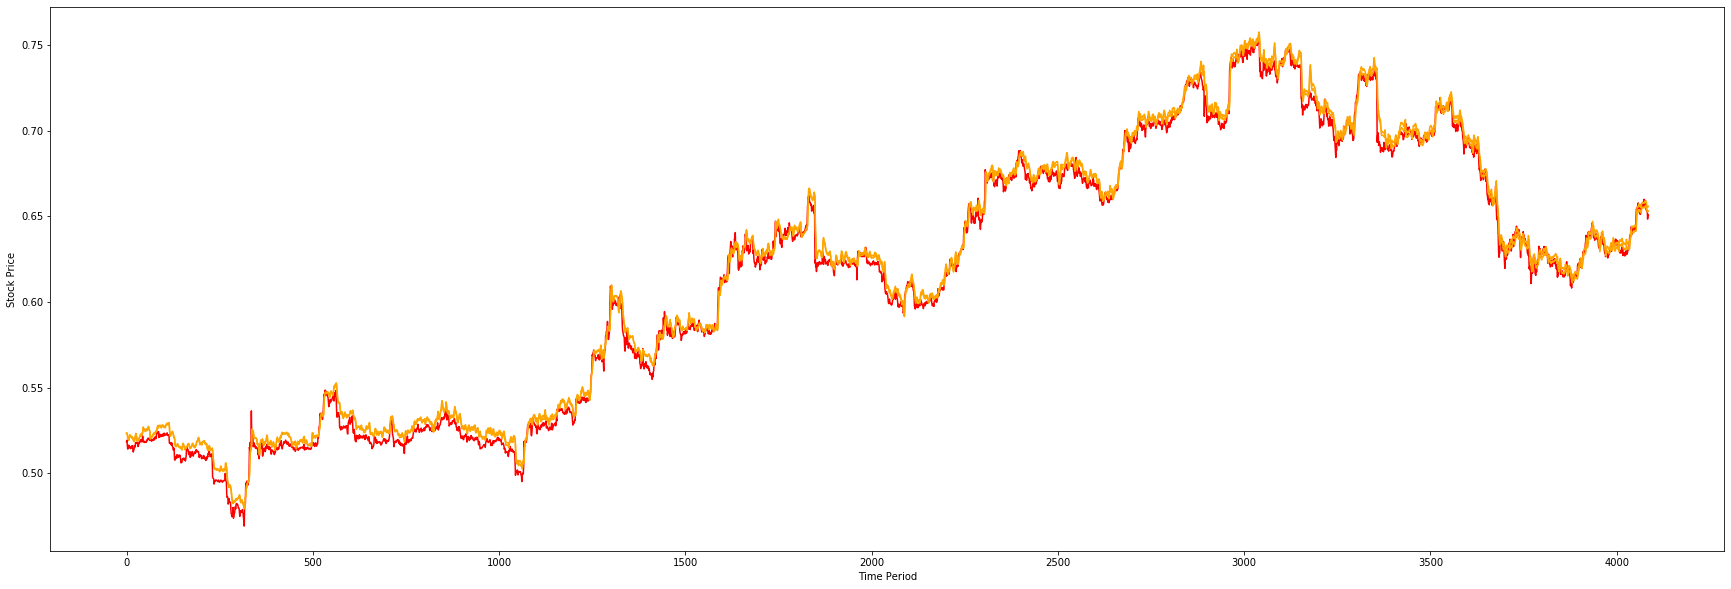

In [57]:
# Test the model
lstm.eval()
test_predict = lstm(x_test)

# Plot predictions
test_predict = test_predict.data.numpy()
real_y = y_test.data.numpy()
plt.figure(figsize=(30, 10))
plt.plot(real_y, color='r')
plt.plot(test_predict, color='orange')
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()

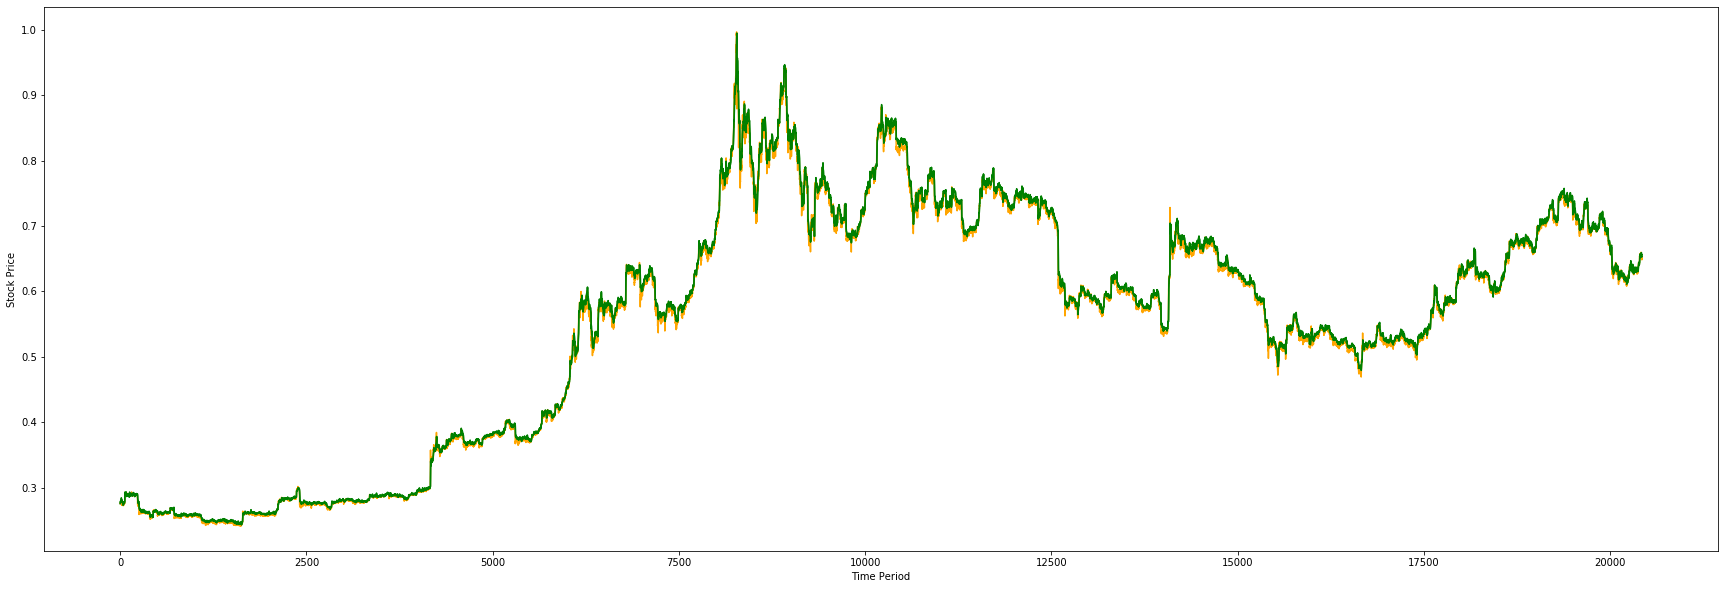

In [58]:
# Test the model
lstm.eval()
test_predict = lstm(x_all)

# Plot predictions
test_predict = test_predict.data.numpy()
real_y = y_all.data.numpy()
plt.figure(figsize=(30, 10))
plt.plot(real_y, color='orange')
plt.plot(test_predict, color='g')
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()